<a href="https://colab.research.google.com/github/KelestZ/HighResImg_Gen/blob/master/gcn_vae_save_snip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip3 install python-igraph
!pip3 install powerlaw

    100% |████████████████████████████████| 378kB 31.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
Successfully built python-igraph
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import os    
os.chdir("/content/gdrive/My Drive/gcn-data/")
!ls


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/
graph_stat.py  __pycache__  sub.label.dat  sub.link.dat  sub.node.dat


In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import numpy as np
from sklearn.manifold import SpectralEmbedding
import torch.optim as optim
import warnings
import scipy.sparse as sp
from pprint import pprint
from graph_stat import *
warnings.filterwarnings("ignore")


In [6]:
a = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0]
])
compute_graph_statistics(a)

Values less than or equal to 0 in data. Throwing out 0 or negative values


{'LCC': 2,
 'claw_count': 0.0,
 'cpl': 1.0,
 'd': 0.6666666666666666,
 'd_max': 1,
 'd_min': 0,
 'edge_num': 1,
 'gini': -0.33333333333333326,
 'n_components': 2,
 'node_num': 3,
 'power_law_exp': inf,
 'rel_edge_distr_entropy': 0.6308387341996874,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 0.0}

In [0]:
import torch
a = torch.Tensor([1]).cuda()
print(a)
torch.cuda.is_available()

tensor([1.], device='cuda:0')


True

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import copy

def show_graph(adj, thresh=.5):
    if not isinstance(adj, np.ndarray):
        adj_ = adj.data.cpu().numpy()
    else:
        adj_ = copy.deepcopy(adj)
    # adj_ = adj_ / np.max(adj_)
    rows, cols = np.where(adj_ > thresh)
    if rows.size == 0:
        print('empty graph to print')
        return
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=30)
    plt.show()
    a = nx.to_numpy_array(gr)
    pprint(compute_graph_statistics(a))
    
    
def make_symmetric(m):
    m_ = torch.transpose(m)
    w = torch.max(m_, m_.T)
    return w


def make_adj(x, n):
    res = torch.zeros(n, n).cuda()
    i = 0
    for r in range(1, n):
        for c in range(r, n):
            res[r, c] = x[i]
            res[c, r] = res[r, c]
            i += 1
    return res


def cat_attr(x, attr_vec):
    if not attr_vec:
        return x
    attr_mat = attr_vec.repeat(x.size()[0], 1)
    x = torch.cat([x, attr_mat], dim=1)
    return x


def get_spectral_embedding(adj, d):
    """
    Given adj is N*N, return its feature mat N*D, D is fixed in model
    :param adj:
    :return:
    """
    '''
    adj_ = adj.data.cpu().numpy()
    emb = SpectralEmbedding(n_components=d)
    res = emb.fit_transform(adj_)
    x = torch.from_numpy(res).float().cuda()
    '''
    x=torch.eye(adj.size()[0]).cuda()
    return x

'''
def normalize(mx):
    """Row-normalize sparse matrix"""
    mx = mx.data.cpu().numpy()
    mx += sp.eye(mx.shape[0])
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return torch.from_numpy(mx).float().cuda()
'''
def normalize(adj):
    adj = adj.data.cpu().numpy()
    adj_ = adj + np.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = np.diag(np.power(rowsum, -0.5).flatten())
    degree_mat_sqrt = np.diag(np.power(rowsum, 0.5).flatten())
    adj_normalized = degree_mat_inv_sqrt.dot(adj_).dot(degree_mat_sqrt)
    return torch.from_numpy(adj_normalized).float().cuda()

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


In [0]:
# from pprint import pprint
# from collections import defaultdict

# NODE_FILE = 'node.dat'
# LINK_FILE = 'link.dat'
# LABEL_FILE = 'label.dat'
# DATA_DIR = 'data'
# mat_names = []
# adj_mats = []
# id_maps = []

# cnt = 0
# for folder in os.listdir(DATA_DIR):
#     cnt += 1
#     if cnt > 100:
#         break
#     mat_names.append(folder)
#     id_to_item = {}
#     with open(os.path.join(DATA_DIR, folder, NODE_FILE), 'r') as f:
#         for i, line in enumerate(f):
#             cells = line.split('\t')
#             id_to_item[i] = cells[0]

#     all_items = set(id_to_item.values())
#     all_ids = set(id_to_item.keys())
        
#     links = defaultdict(set)
#     with open(os.path.join(DATA_DIR, folder, LINK_FILE), 'r') as f:
#         for line in f:
#             cells = line.rstrip('\n').split('\t')
#             from_id = int(cells[0])
#             to_id = int(cells[1])
#             if from_id in all_ids and to_id in all_ids:
#                 links[from_id].add(to_id)
    
#     N = len(all_ids)
#     adj = np.zeros((N, N))
#     for from_id in range(N):
#         for to_id in links[i]:
#             adj[from_id, to_id] = 1
#             adj[to_id, from_id] = 1
#     id_map = [id_to_item[i] for i in range(N)]
    
#     adj_mats.append(adj)
#     id_maps.append(id_map)
    

# t_adj_mats = [torch.from_numpy(m).float() for m in adj_mats]
# torch.manual_seed(0)
# t_attr_vecs = torch.randn(len(t_adj_mats), 8)
    

# for i in range(3):
#     print('No:', i, mat_names[i])
#     print('Adj Mat', adj_mats[i].shape)
#     print(adj_mats[i])
#     show_graph(adj_mats[i])
#     print('# of nodes', len(id_maps[i]))
#     print('# of links', np.count_nonzero(adj_mats[i]) // 2)
#     print('Item names', id_maps[i])
#     print('Attr vec', t_attr_vecs[i, :])


In [8]:
from pprint import pprint
from collections import defaultdict

NODE_FILE = 'sub.node.dat'
LINK_FILE = 'sub.link.dat'
LABEL_FILE = 'sub.label.dat'

id_to_author = {}
id_to_fv = {}
with open(NODE_FILE, 'r') as f:
    for i, line in enumerate(f):
        cells = line.split('\t')
        if cells[1] == '1':
            id_to_author[i] = cells[0]
            id_to_fv[i] = np.asarray([float(a) for a in cells[-1].split(',')])
all_authors = set(id_to_author.values())
all_ids = set(id_to_author.keys())

sg_to_ids = defaultdict(list)
author_to_id = {v: k for k, v in id_to_author.items()}
with open(LABEL_FILE, 'r') as f:
    for line in f:
        cells = line.rstrip('\n').split('\t')
        if cells[1] == '1' and cells[0] in all_authors:
            sg_to_ids[int(cells[2])].append(author_to_id[cells[0]])
for k, v in sg_to_ids.items():
    v.sort()
    
links = defaultdict(set)
with open(LINK_FILE, 'r') as f:
    for line in f:
        cells = line.rstrip('\n').split('\t')
        from_id = int(cells[0])
        to_id = int(cells[1])
        if from_id in all_ids and to_id in all_ids:
            links[from_id].add(to_id)
print('total links', sum(len(s) for s in links.values()))

adj_mats = []
id_maps = []
author_maps = []
feature_mats = []
M = len(id_to_fv[15055])
for sg, ids in sg_to_ids.items():
    N = len(ids)
    cur_ids = set(ids)
    adj_mat = np.zeros((N, N))
    feature_mat = np.zeros((N, M))
    row_map = {id: i for i, id in enumerate(ids)}
    for id in ids:
        for to_id in links[id]:
            if to_id not in cur_ids:
                continue
            r = row_map[id]
            c = row_map[to_id]
            adj_mat[r, c] = 1
            adj_mat[c, r] = 1
            feature_mat[r, :] = id_to_fv[id]
    adj_mats.append(adj_mat)
    id_maps.append(ids)
    author_maps.append([id_to_author[id] for id in ids])
    feature_mats.append(feature_mat)

for i in range(len(adj_mats)):
    print('Sub Group:', i)
    print('Adj Mat', adj_mats[i].shape)
    print(adj_mats[i])
    print('Feature Mat', feature_mats[i].shape)
    print(feature_mats[i])
    print('# of nodes', len(id_maps[i]))
    print('# of links', np.count_nonzero(adj_mats[i]) // 2)
    print('Author IDs', id_maps[i])
    print('Author Names', author_maps[i])



total links 89338
Sub Group: 0
Adj Mat (85, 85)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Feature Mat (85, 300)
[[ 0.07215603  0.06144113  0.05818894 ... -0.02154668  0.00698567
   0.07824665]
 [ 0.05516684  0.06795543  0.05596303 ... -0.00699321  0.03945775
   0.07380445]
 [ 0.08410812  0.06211852  0.09581563 ... -0.02434913  0.02596578
   0.09632713]
 ...
 [ 0.06386379  0.0458215   0.03929755 ... -0.01344742  0.04175031
   0.04113219]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.04986971  0.07809608  0.15042931 ... -0.01264195 -0.00130667
   0.1547265 ]]
# of nodes 85
# of links 592
Author IDs [15041, 15050, 15055, 15059, 15064, 15071, 15107, 15116, 15117, 15122, 15129, 15131, 15135, 15148, 15153, 15175, 15180, 15215, 15224, 15235, 15240, 15258, 15266, 15277, 15300, 15328, 15330, 15366, 15387, 15411, 15412, 15415, 15430, 15461, 15512, 1552

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


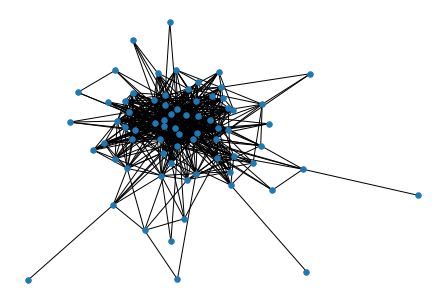

{'LCC': 72,
 'claw_count': 149220.0,
 'cpl': 1.880281690140845,
 'd': 16.444444444444443,
 'd_max': 66.0,
 'd_min': 1.0,
 'edge_num': 592,
 'gini': 0.36111111111111116,
 'n_components': 1,
 'node_num': 72,
 'power_law_exp': 1.4047061319794967,
 'rel_edge_distr_entropy': 0.9408530669866471,
 'square_count': 6172,
 'triangle_count': 2390,
 'wedge_count': 14270.0}
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


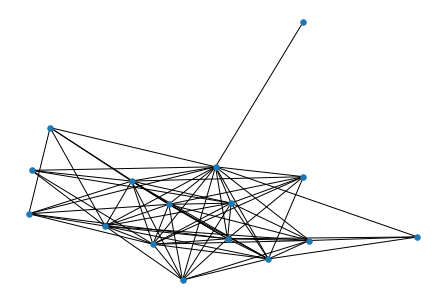

{'LCC': 16,
 'claw_count': 2147.0,
 'cpl': 1.4,
 'd': 9.0,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 72,
 'gini': 0.1015625,
 'n_components': 1,
 'node_num': 16,
 'power_law_exp': 1.487510385592949,
 'rel_edge_distr_entropy': 0.9636760198696733,
 'square_count': 261,
 'triangle_count': 174,
 'wedge_count': 685.0}
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


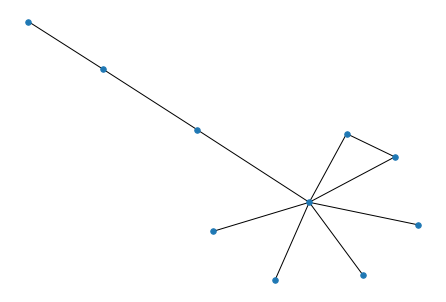

{'LCC': 10,
 'claw_count': 34.99999999999999,
 'cpl': 2.2,
 'd': 2.0,
 'd_max': 7.0,
 'd_min': 1.0,
 'edge_num': 10,
 'gini': 0.1499999999999999,
 'n_components': 1,
 'node_num': 10,
 'power_law_exp': 3.119318086698044,
 'rel_edge_distr_entropy': 0.8848119694447857,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 25.0}
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


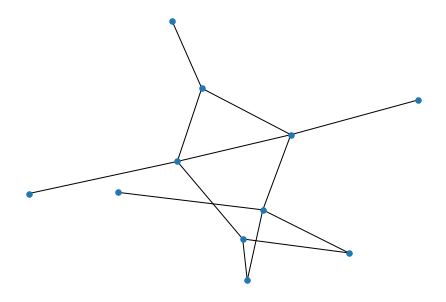

{'LCC': 11,
 'claw_count': 14.0,
 'cpl': 2.2181818181818183,
 'd': 2.3636363636363638,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 13,
 'gini': 0.104895104895105,
 'n_components': 1,
 'node_num': 11,
 'power_law_exp': 2.4207477174403085,
 'rel_edge_distr_entropy': 0.9416850476998382,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 26.0}
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


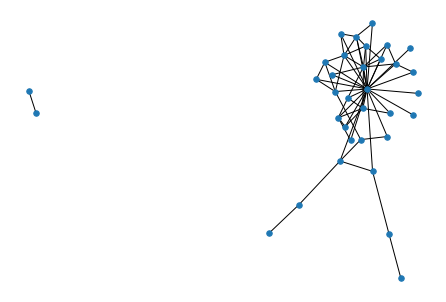

{'LCC': 32,
 'claw_count': 2848.0,
 'cpl': 2.2293762575452716,
 'd': 3.823529411764706,
 'd_max': 26.0,
 'd_min': 1.0,
 'edge_num': 65,
 'gini': 0.3719457013574661,
 'n_components': 2,
 'node_num': 34,
 'power_law_exp': 1.9798534814093034,
 'rel_edge_distr_entropy': 0.8931277157389573,
 'square_count': 13,
 'triangle_count': 43,
 'wedge_count': 504.0}
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


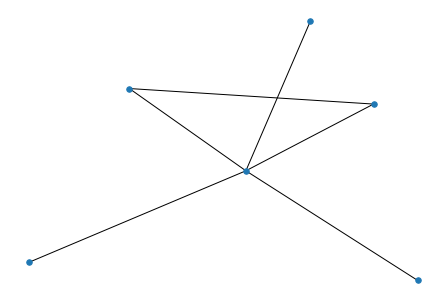

{'LCC': 6,
 'claw_count': 10.0,
 'cpl': 1.6,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': 0.0,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.0028492041720045,
 'rel_edge_distr_entropy': 0.883605466225036,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 12.0}
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


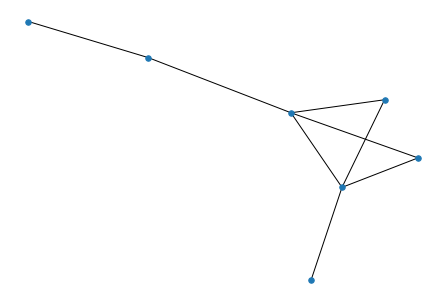

{'LCC': 7,
 'claw_count': 8.0,
 'cpl': 1.9047619047619047,
 'd': 2.2857142857142856,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 8,
 'gini': -0.017857142857142794,
 'n_components': 1,
 'node_num': 7,
 'power_law_exp': 2.4426950408889634,
 'rel_edge_distr_entropy': 0.9350213837484218,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 15.0}
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


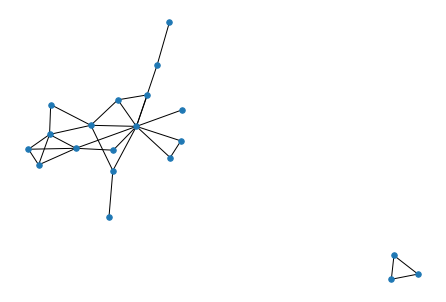

{'LCC': 17,
 'claw_count': 154.0,
 'cpl': 2.20863309352518,
 'd': 2.9,
 'd_max': 10.0,
 'd_min': 1.0,
 'edge_num': 29,
 'gini': 0.21896551724137936,
 'n_components': 2,
 'node_num': 20,
 'power_law_exp': 2.1258933014072623,
 'rel_edge_distr_entropy': 0.9362530304267763,
 'square_count': 1,
 'triangle_count': 11,
 'wedge_count': 96.0}
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


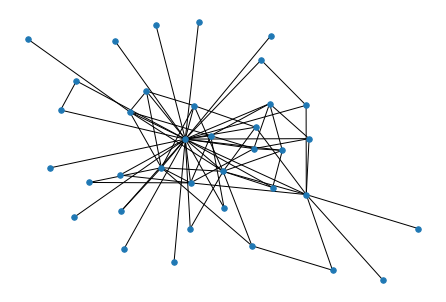

{'LCC': 37,
 'claw_count': 4488.0,
 'cpl': 2.108108108108108,
 'd': 4.0,
 'd_max': 30.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.4353542731921112,
 'n_components': 1,
 'node_num': 37,
 'power_law_exp': 2.0294713010262613,
 'rel_edge_distr_entropy': 0.8719007839079403,
 'square_count': 11,
 'triangle_count': 48,
 'wedge_count': 684.0}
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
empty graph to print
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


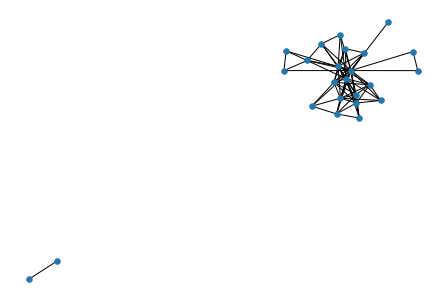

{'LCC': 22,
 'claw_count': 2620.0,
 'cpl': 1.668103448275862,
 'd': 6.416666666666667,
 'd_max': 21.0,
 'd_min': 1.0,
 'edge_num': 77,
 'gini': 0.30573593073593064,
 'n_components': 2,
 'node_num': 24,
 'power_law_exp': 1.6389288565965399,
 'rel_edge_distr_entropy': 0.9210143240810383,
 'square_count': 126,
 'triangle_count': 127,
 'wedge_count': 686.0}
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


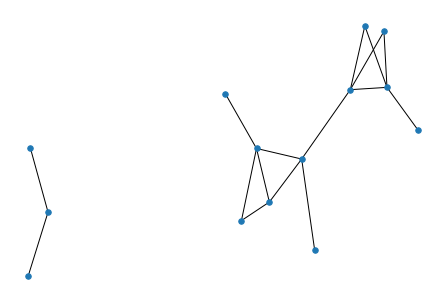

{'LCC': 11,
 'claw_count': 17.0,
 'cpl': 2.3793103448275863,
 'd': 2.2857142857142856,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 16,
 'gini': 0.1473214285714286,
 'n_components': 2,
 'node_num': 14,
 'power_law_exp': 2.486771168589777,
 'rel_edge_distr_entropy': 0.9458920230062228,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 31.0}
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
empty graph to print


In [9]:
t_adj_mats = [torch.from_numpy(m).float() for m in adj_mats]
t_attr_vecs = torch.eye(len(adj_mats))

for i in range(13):
    print(t_attr_vecs[i])
    a = t_adj_mats[i]
    show_graph(a)

In [0]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [0]:
class Encoder(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, rep_size):
        """

        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D'
        :param z_size: z
        """
        super(Encoder, self).__init__()
        # input parameters
        self.z_size = z_size
        self.attr_vec = None
        self.gc_size = gc_size
        self.z_size = z_size
        self.d_size = d_size
        self.av_size = av_size
        self.rep_size = rep_size
        
        self.gc = GraphConvolution(d_size + av_size, gc_size)
        self.gc_mu = GraphConvolution(gc_size, z_size)
        self.gc_logvar = GraphConvolution(gc_size, z_size)
        
        self.mean = nn.Sequential( nn.Linear(gc_size, z_size))

        self.logvar = nn.Sequential(nn.Linear(gc_size, z_size)) #nn.ReLU(),
     
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec

    def forward(self, adj):
        x = get_spectral_embedding(adj, d=self.d_size)
        adj = normalize(adj)
        x = cat_attr(x, self.attr_vec)
        x = F.relu(self.gc(x, adj))
        x = F.dropout(x, p=0.5)
        
        #z_mean = self.gc_mu(x, adj)
        #z_logvar = self.gc_logvar(x, adj)
        
        # create graph embedding N*D' -> 1*D'
        # x = x.sum(0)
        z_mean = self.mean(x)
        z_logvar = self.logvar(x)
        
        # feature III here
        #z_mean = torch.mean(z_mean, 0)
        #z_mean = z_mean.repeat(z_logvar.shape[0], 1)

        return z_mean, z_logvar

In [0]:
class Decoder(nn.Module):
    def __init__(self, z_out_size, rep_size):
        """
        :param z_out_size: = z_size + len(attr_vec)
        """
        super(Decoder, self).__init__()
        self.z_out_size = z_out_size
        self.rep_size = rep_size
        '''
        self.decode = nn.Sequential(
            nn.Linear(z_out_size, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU())
        '''
        self.decode = nn.Sequential(
            #nn.Linear(z_out_size, self.rep_size),
            #nn.BatchNorm1d(self.rep_size),
            #nn.ReLU(),
            nn.Linear(z_out_size, int(self.rep_size)),
            nn.BatchNorm1d(int(self.rep_size)),
            nn.ReLU(),
            nn.Linear(int(self.rep_size), int(self.rep_size/2)),
            #nn.BatchNorm1d(int(self.rep_size/2)),
            #nn.ReLU()
            )#nn.BatchNorm1d(int(self.rep_size/4)),

        
    def forward(self, z):
        x = self.decode(z)
        # x = z
        x = torch.mm(x, x.t())
        #x = F.sigmoid(x)
        return x

In [0]:
class Generator(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, z_out_size, rep_size):
        """

        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D' = GCN(D_X + D_A)
        :param z_size: original z size
        :param z_out_size: z size + D_A (append attribute)
        """
        super(Generator, self).__init__()
        self.attr_vec = None
        self.av_size = av_size
        self.d_zize = d_size
        self.z_size = z_size
        self.z_out_size = z_out_size
        self.rep_size = rep_size

        self.encoder = Encoder(av_size, d_size, gc_size, z_size, rep_size)
        self.decoder = Decoder(z_out_size,rep_size)
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec
        self.encoder.set_attr_vec(attr_vec)
   
    def forward(self, adj, training=True):
        mean, logvar = self.encoder(adj)
        if(training):
            std = logvar.mul(0.5).exp_()
            reparametrized_noise = torch.randn(mean.shape, requires_grad=True).cuda()
            reparametrized_noise = mean + std * reparametrized_noise
        else:
            reparametrized_noise = mean
            # print('mean',mean)
        x = cat_attr(reparametrized_noise, self.attr_vec)
        rec_x = self.decoder(x)
        return mean, logvar, rec_x

In [0]:
class Discriminator(nn.Module):
    def __init__(self, av_size, d_size, gc_size, rep_size):
        super(Discriminator, self).__init__()
        self.av_size = av_size
        self.attr_vec = None
        self.d_size = d_size
        self.gc_size = gc_size
        self.rep_size = rep_size
        self.gc = GraphConvolution(d_size + av_size, gc_size)
        self.gc2 = GraphConvolution(gc_size, 8)
        
        self.main = nn.Sequential(
            nn.Linear(gc_size, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
        )

        self.sigmoid_output = nn.Sequential(
            nn.Linear(8, 1),
            nn.Sigmoid())
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec

    def forward(self, adj):
        # get spectral embedding from adj, D = D_X
        x = get_spectral_embedding(adj, d=self.d_size)
        adj = normalize(adj)
        x = cat_attr(x, self.attr_vec)

        # GCN layer N*D -> N*D'
        x = F.relu(self.gc(x, adj))
        # x = F.relu(self.gc2(x, adj))
        
        # x = F.dropout(x, p=0.5)
        x = self.main(x)
        x = x.sum(0)
        
        x = self.sigmoid_output(x)

        return x

    def similarity(self, adj):
        # get spectral embedding from adj, D = D_X
        x = get_spectral_embedding(adj, d=self.d_size)
        
        # norm adj
        adj = normalize(adj)

        # concatenate attr mat, D = D_X + D_A
        x = cat_attr(x, self.attr_vec)

        # GCN layer N*D -> N*D'
        x = F.relu(self.gc(x, adj))
        x = F.dropout(x, p=0.5)
        #x = F.relu(self.gc2(x, adj))
        # create graph embedding N*D' -> 1*D'
        x = self.main(x)
        # x = x.sum(0)
        # skip the last sigmoid layer
        # x = self.main(x)
        
        return x

In [0]:
def sample_adj(adj):
    adj_sample = adj.data.cpu()
    for i in range(adj.size(0)):
        for j in range(adj.size(1)):
            a = torch.bernoulli(adj.data[i, j])
            adj_sample[i, j] = a
    adj_sample = torch.min(adj_sample, adj_sample.t())
    return adj_sample.cuda()

In [0]:
def top_n_indexes(arr, n):
    idx = np.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

def topk_adj(adj, k):
    adj_ = adj.data.cpu().numpy()
    assert((adj_ == adj_.T).all())
    adj_ = (adj_-np.min(adj_)) / np.ptp(adj_)
    adj_ -= np.diag(np.diag(adj_))
    inds = top_n_indexes(adj_, k)
    res = torch.zeros(adj.shape)
    for ind in inds:
        res[ind] = 1.0
    return res.cuda()

encoder.gc.weight        torch.Size([50, 16])
encoder.gc.bias        torch.Size([16])
encoder.gc_mu.weight        torch.Size([16, 32])
encoder.gc_mu.bias        torch.Size([32])
encoder.gc_logvar.weight        torch.Size([16, 32])
encoder.gc_logvar.bias        torch.Size([32])
encoder.mean.0.weight        torch.Size([32, 16])
encoder.mean.0.bias        torch.Size([32])
encoder.logvar.0.weight        torch.Size([32, 16])
encoder.logvar.0.bias        torch.Size([32])
decoder.decode.0.weight        torch.Size([16, 32])
decoder.decode.0.bias        torch.Size([16])
decoder.decode.1.weight        torch.Size([16])
decoder.decode.1.bias        torch.Size([16])
decoder.decode.3.weight        torch.Size([8, 16])
decoder.decode.3.bias        torch.Size([8])
[0/2000]: vae_loss:1.7444, prior_loss:4.6929
max tensor(1.8919, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.7488, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5472, 0.5153, 0.5582,  ..., 0.5246, 0.5162, 0.

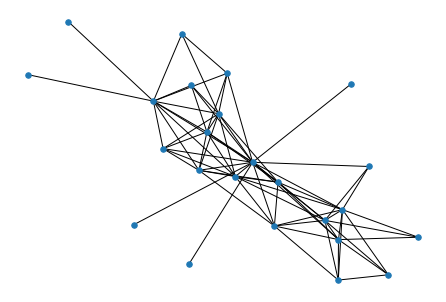

{'LCC': 24,
 'claw_count': 1712.0,
 'cpl': 1.9963768115942029,
 'd': 6.166666666666667,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.28434684684684686,
 'n_components': 1,
 'node_num': 24,
 'power_law_exp': 1.6638401156519507,
 'rel_edge_distr_entropy': 0.9262440211504578,
 'square_count': 92,
 'triangle_count': 110,
 'wedge_count': 583.0}


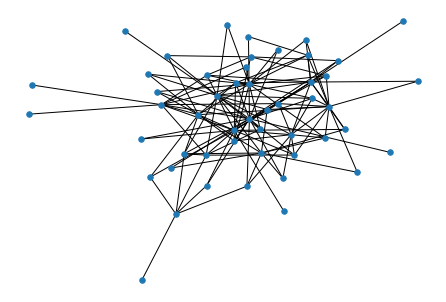

{'LCC': 50,
 'claw_count': 4121.0,
 'cpl': 2.3412244897959185,
 'd': 5.4,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.3925925925925926,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7391504999400538,
 'rel_edge_distr_entropy': 0.9203743435467999,
 'square_count': 2,
 'triangle_count': 52,
 'wedge_count': 1122.0}
[30/2000]: vae_loss:1.6419, prior_loss:2.1665
max tensor(3.6786, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.5397, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5298, 0.5170, 0.5262,  ..., 0.5254, 0.5179, 0.5154],
        [0.5170, 0.5622, 0.5178,  ..., 0.5272, 0.5229, 0.5062],
        [0.5262, 0.5178, 0.5284,  ..., 0.5232, 0.5160, 0.5237],
        ...,
        [0.5254, 0.5272, 0.5232,  ..., 0.5259, 0.5198, 0.5130],
        [0.5179, 0.5229, 0.5160,  ..., 0.5198, 0.5162, 0.5098],
        [0.5154, 0.5062, 0.5237,  ..., 0.5130, 0.5098, 0.5376]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


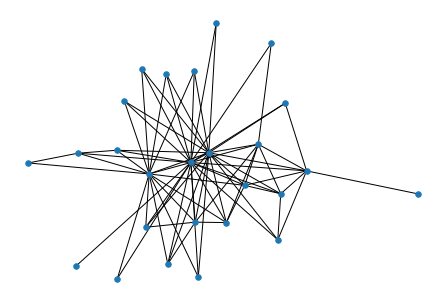

{'LCC': 26,
 'claw_count': 3548.0,
 'cpl': 1.8523076923076922,
 'd': 5.6923076923076925,
 'd_max': 23.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3586278586278586,
 'n_components': 1,
 'node_num': 26,
 'power_law_exp': 1.7068582940119996,
 'rel_edge_distr_entropy': 0.8961078756855777,
 'square_count': 50,
 'triangle_count': 87,
 'wedge_count': 724.0}


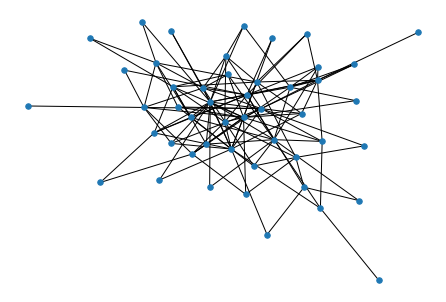

{'LCC': 48,
 'claw_count': 2997.0,
 'cpl': 2.345744680851064,
 'd': 5.5,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 132,
 'gini': 0.34706439393939403,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.6944455586874878,
 'rel_edge_distr_entropy': 0.937113678616775,
 'square_count': 9,
 'triangle_count': 64,
 'wedge_count': 980.0}
[60/2000]: vae_loss:1.6070, prior_loss:1.0478
max tensor(3.0559, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.1665, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.6218, 0.5317, 0.6121,  ..., 0.5313, 0.5250, 0.5625],
        [0.5317, 0.5442, 0.5357,  ..., 0.5262, 0.5403, 0.5444],
        [0.6121, 0.5357, 0.6279,  ..., 0.5271, 0.5425, 0.5758],
        ...,
        [0.5313, 0.5262, 0.5271,  ..., 0.5267, 0.5241, 0.5299],
        [0.5250, 0.5403, 0.5425,  ..., 0.5241, 0.5487, 0.5407],
        [0.5625, 0.5444, 0.5758,  ..., 0.5299, 0.5407, 0.5772]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


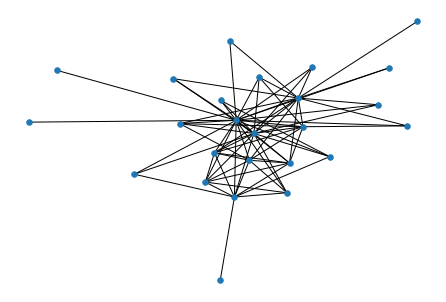

{'LCC': 25,
 'claw_count': 3024.0,
 'cpl': 1.83,
 'd': 5.92,
 'd_max': 22.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.365945945945946,
 'n_components': 1,
 'node_num': 25,
 'power_law_exp': 1.7073548194088235,
 'rel_edge_distr_entropy': 0.8971554555756519,
 'square_count': 73,
 'triangle_count': 100,
 'wedge_count': 702.0}


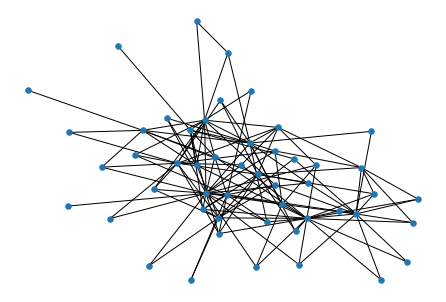

{'LCC': 50,
 'claw_count': 4061.0,
 'cpl': 2.31265306122449,
 'd': 5.52,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 138,
 'gini': 0.3679710144927537,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7008053651546637,
 'rel_edge_distr_entropy': 0.9293180175474816,
 'square_count': 3,
 'triangle_count': 48,
 'wedge_count': 1121.0}
[90/2000]: vae_loss:1.6627, prior_loss:0.5760
max tensor(3.9185, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.4331, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5303, 0.5273, 0.5411,  ..., 0.5187, 0.5189, 0.5226],
        [0.5273, 0.5643, 0.5402,  ..., 0.5279, 0.5151, 0.5157],
        [0.5411, 0.5402, 0.6691,  ..., 0.5235, 0.5336, 0.5171],
        ...,
        [0.5187, 0.5279, 0.5235,  ..., 0.5261, 0.5245, 0.5024],
        [0.5189, 0.5151, 0.5336,  ..., 0.5245, 0.5336, 0.4844],
        [0.5226, 0.5157, 0.5171,  ..., 0.5024, 0.4844, 0.5824]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


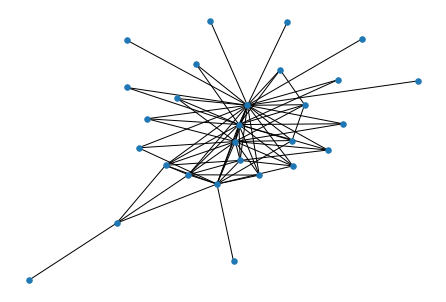

{'LCC': 28,
 'claw_count': 3715.0,
 'cpl': 1.9761904761904763,
 'd': 5.285714285714286,
 'd_max': 24.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.426158301158301,
 'n_components': 1,
 'node_num': 28,
 'power_law_exp': 1.819935705227556,
 'rel_edge_distr_entropy': 0.8719886420996769,
 'square_count': 73,
 'triangle_count': 94,
 'wedge_count': 747.0}


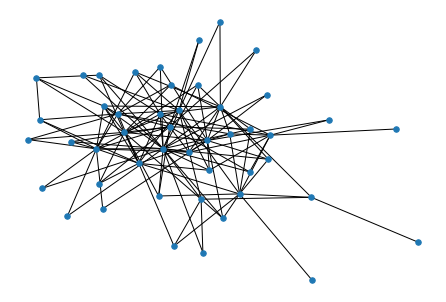

{'LCC': 47,
 'claw_count': 3955.0,
 'cpl': 2.27104532839963,
 'd': 5.574468085106383,
 'd_max': 22.0,
 'd_min': 1.0,
 'edge_num': 131,
 'gini': 0.36706188078609725,
 'n_components': 1,
 'node_num': 47,
 'power_law_exp': 1.6997532911791464,
 'rel_edge_distr_entropy': 0.9275630940546306,
 'square_count': 5,
 'triangle_count': 58,
 'wedge_count': 1075.0}
[120/2000]: vae_loss:1.5404, prior_loss:0.4210
max tensor(2.9885, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.2877, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5407, 0.5303, 0.5208,  ..., 0.5226, 0.5347, 0.5591],
        [0.5303, 0.5849, 0.5117,  ..., 0.5151, 0.6176, 0.5548],
        [0.5208, 0.5117, 0.5212,  ..., 0.5192, 0.5077, 0.5127],
        ...,
        [0.5226, 0.5151, 0.5192,  ..., 0.5269, 0.5044, 0.5205],
        [0.5347, 0.6176, 0.5077,  ..., 0.5044, 0.6739, 0.5737],
        [0.5591, 0.5548, 0.5127,  ..., 0.5205, 0.5737, 0.6220]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


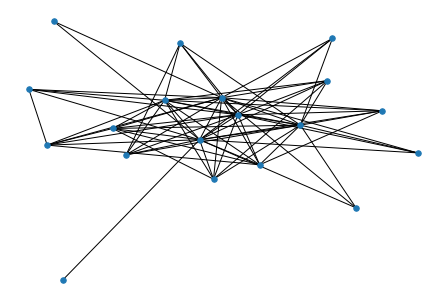

{'LCC': 19,
 'claw_count': 2736.0,
 'cpl': 1.5730994152046784,
 'd': 7.7894736842105265,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.2339971550497868,
 'n_components': 1,
 'node_num': 19,
 'power_law_exp': 1.5461702210653336,
 'rel_edge_distr_entropy': 0.935597914077363,
 'square_count': 154,
 'triangle_count': 141,
 'wedge_count': 725.0}


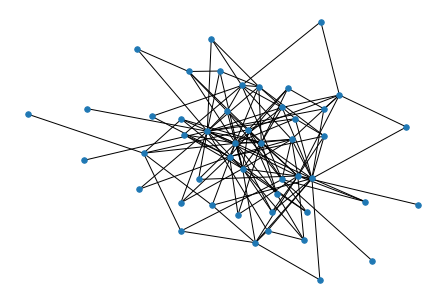

{'LCC': 48,
 'claw_count': 3669.0,
 'cpl': 2.359042553191489,
 'd': 5.583333333333333,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3580534825870647,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.6960414216685407,
 'rel_edge_distr_entropy': 0.9319105394808928,
 'square_count': 10,
 'triangle_count': 66,
 'wedge_count': 1064.0}
[150/2000]: vae_loss:1.7007, prior_loss:0.2897
max tensor(4.2732, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.6111, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5392, 0.5299, 0.5227,  ..., 0.5256, 0.5295, 0.5187],
        [0.5299, 0.5799, 0.5133,  ..., 0.5270, 0.5799, 0.5028],
        [0.5227, 0.5133, 0.5221,  ..., 0.5164, 0.5128, 0.5171],
        ...,
        [0.5256, 0.5270, 0.5164,  ..., 0.5267, 0.5213, 0.5073],
        [0.5295, 0.5799, 0.5128,  ..., 0.5213, 0.5856, 0.5028],
        [0.5187, 0.5028, 0.5171,  ..., 0.5073, 0.5028, 0.5253]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


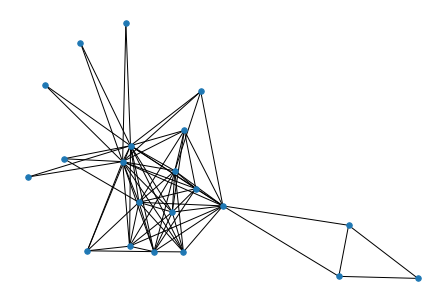

{'LCC': 21,
 'claw_count': 2470.0,
 'cpl': 1.8142857142857143,
 'd': 7.0476190476190474,
 'd_max': 17.0,
 'd_min': 2.0,
 'edge_num': 74,
 'gini': 0.28120978120978113,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 2.0013701706933187,
 'rel_edge_distr_entropy': 0.9248757486111235,
 'square_count': 190,
 'triangle_count': 144,
 'wedge_count': 689.0}


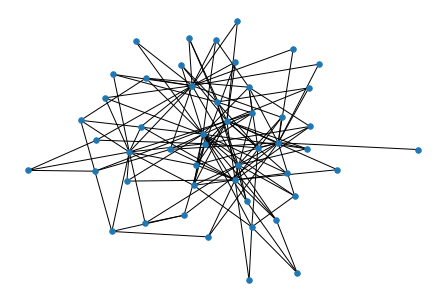

{'LCC': 49,
 'claw_count': 4347.0,
 'cpl': 2.241496598639456,
 'd': 5.591836734693878,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 137,
 'gini': 0.3436615522121258,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6769067357753333,
 'rel_edge_distr_entropy': 0.9329386400383621,
 'square_count': 2,
 'triangle_count': 46,
 'wedge_count': 1131.0}
[180/2000]: vae_loss:1.6747, prior_loss:0.2067
max tensor(2.9651, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.5708, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5364, 0.5224, 0.5281,  ..., 0.5332, 0.5178, 0.5281],
        [0.5224, 0.5381, 0.5154,  ..., 0.5349, 0.5127, 0.5155],
        [0.5281, 0.5154, 0.5408,  ..., 0.5313, 0.5221, 0.5060],
        ...,
        [0.5332, 0.5349, 0.5313,  ..., 0.5520, 0.5193, 0.5124],
        [0.5178, 0.5127, 0.5221,  ..., 0.5193, 0.5216, 0.5094],
        [0.5281, 0.5155, 0.5060,  ..., 0.5124, 0.5094, 0.5422]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


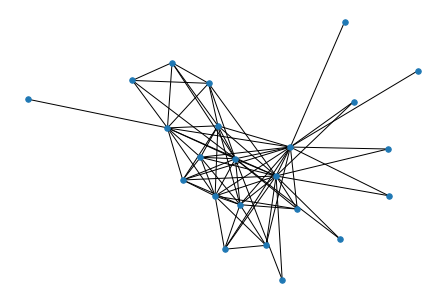

{'LCC': 23,
 'claw_count': 2350.0,
 'cpl': 1.8300395256916997,
 'd': 6.434782608695652,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.326674500587544,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.6592856373003597,
 'rel_edge_distr_entropy': 0.9107143140735376,
 'square_count': 141,
 'triangle_count': 126,
 'wedge_count': 669.0}


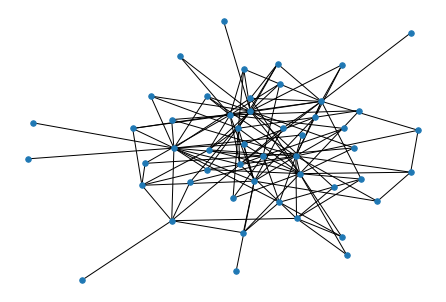

{'LCC': 50,
 'claw_count': 3375.0,
 'cpl': 2.329795918367347,
 'd': 5.28,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 132,
 'gini': 0.3628787878787878,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7260172557645284,
 'rel_edge_distr_entropy': 0.9302811675385243,
 'square_count': 0,
 'triangle_count': 33,
 'wedge_count': 1007.0}
[210/2000]: vae_loss:1.5549, prior_loss:0.1351
max tensor(4.7693, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.2296, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5368, 0.5211, 0.5262,  ..., 0.5127, 0.5170, 0.5133],
        [0.5211, 0.5249, 0.5132,  ..., 0.5059, 0.5070, 0.5097],
        [0.5262, 0.5132, 0.5445,  ..., 0.5122, 0.5422, 0.5263],
        ...,
        [0.5127, 0.5059, 0.5122,  ..., 0.5427, 0.5212, 0.4986],
        [0.5170, 0.5070, 0.5422,  ..., 0.5212, 0.5545, 0.5181],
        [0.5133, 0.5097, 0.5263,  ..., 0.4986, 0.5181, 0.5240]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


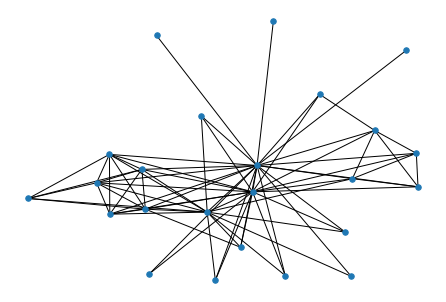

{'LCC': 24,
 'claw_count': 3177.0,
 'cpl': 1.7608695652173914,
 'd': 6.166666666666667,
 'd_max': 22.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3417792792792793,
 'n_components': 1,
 'node_num': 24,
 'power_law_exp': 1.6713585941074727,
 'rel_edge_distr_entropy': 0.9039868987454273,
 'square_count': 105,
 'triangle_count': 111,
 'wedge_count': 713.0}


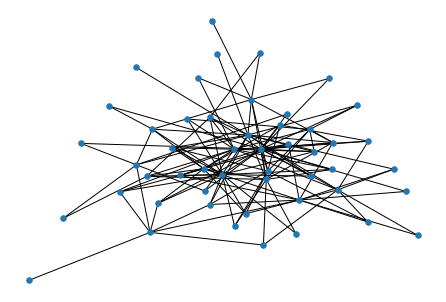

{'LCC': 50,
 'claw_count': 4167.0,
 'cpl': 2.3012244897959184,
 'd': 5.4,
 'd_max': 21.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.3751111111111112,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.7176897961375777,
 'rel_edge_distr_entropy': 0.9265706562750387,
 'square_count': 1,
 'triangle_count': 48,
 'wedge_count': 1100.0}
[240/2000]: vae_loss:1.6013, prior_loss:0.1159
max tensor(2.3461, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.3296, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5231, 0.5169, 0.5231,  ..., 0.5230, 0.5174, 0.5266],
        [0.5169, 0.5708, 0.5169,  ..., 0.5335, 0.5892, 0.5329],
        [0.5231, 0.5169, 0.5231,  ..., 0.5230, 0.5174, 0.5266],
        ...,
        [0.5230, 0.5335, 0.5230,  ..., 0.5331, 0.5337, 0.5374],
        [0.5174, 0.5892, 0.5174,  ..., 0.5337, 0.6253, 0.5348],
        [0.5266, 0.5329, 0.5266,  ..., 0.5374, 0.5348, 0.6107]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


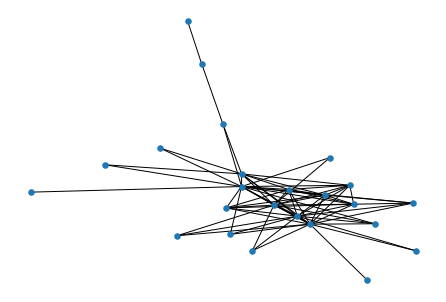

{'LCC': 24,
 'claw_count': 2498.0,
 'cpl': 2.039855072463768,
 'd': 6.166666666666667,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.35641891891891886,
 'n_components': 1,
 'node_num': 24,
 'power_law_exp': 1.690454949649479,
 'rel_edge_distr_entropy': 0.9004491772065462,
 'square_count': 157,
 'triangle_count': 128,
 'wedge_count': 683.0}


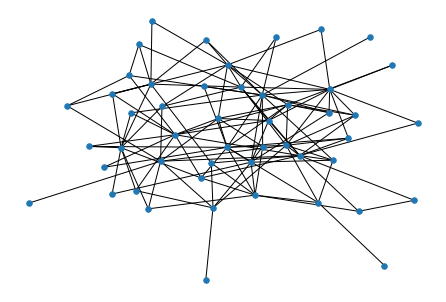

{'LCC': 49,
 'claw_count': 2155.0,
 'cpl': 2.441326530612245,
 'd': 5.224489795918367,
 'd_max': 14.0,
 'd_min': 1.0,
 'edge_num': 128,
 'gini': 0.3287627551020409,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7094763534000923,
 'rel_edge_distr_entropy': 0.9439326724177148,
 'square_count': 1,
 'triangle_count': 43,
 'wedge_count': 845.0}
[270/2000]: vae_loss:1.6942, prior_loss:0.0787
max tensor(4.1927, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.2346, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5249, 0.5263, 0.5205,  ..., 0.5132, 0.5265, 0.5204],
        [0.5263, 0.5297, 0.5174,  ..., 0.5113, 0.5264, 0.5193],
        [0.5205, 0.5174, 0.6769,  ..., 0.5200, 0.5539, 0.6162],
        ...,
        [0.5132, 0.5113, 0.5200,  ..., 0.5254, 0.5012, 0.5211],
        [0.5265, 0.5264, 0.5539,  ..., 0.5012, 0.5851, 0.5284],
        [0.5204, 0.5193, 0.6162,  ..., 0.5211, 0.5284, 0.5812]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


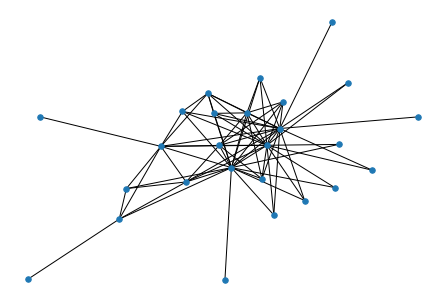

{'LCC': 26,
 'claw_count': 2991.0,
 'cpl': 1.9384615384615385,
 'd': 5.6923076923076925,
 'd_max': 19.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.38305613305613306,
 'n_components': 1,
 'node_num': 26,
 'power_law_exp': 1.7431576845501726,
 'rel_edge_distr_entropy': 0.8905979205549931,
 'square_count': 77,
 'triangle_count': 100,
 'wedge_count': 700.0}


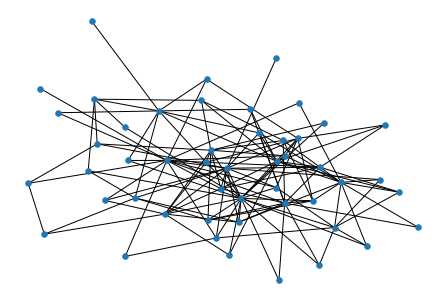

{'LCC': 49,
 'claw_count': 3360.0,
 'cpl': 2.307823129251701,
 'd': 5.510204081632653,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 135,
 'gini': 0.3377173091458805,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6843912290045524,
 'rel_edge_distr_entropy': 0.9395407057368138,
 'square_count': 3,
 'triangle_count': 52,
 'wedge_count': 1013.0}
[300/2000]: vae_loss:1.5766, prior_loss:0.0761
max tensor(2.9841, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.8513, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5251, 0.5220, 0.5121,  ..., 0.5199, 0.5174, 0.5216],
        [0.5220, 0.5397, 0.5262,  ..., 0.5260, 0.5393, 0.5258],
        [0.5121, 0.5262, 0.5289,  ..., 0.5171, 0.5347, 0.5178],
        ...,
        [0.5199, 0.5260, 0.5171,  ..., 0.5226, 0.5228, 0.5192],
        [0.5174, 0.5393, 0.5347,  ..., 0.5228, 0.5878, 0.5150],
        [0.5216, 0.5258, 0.5178,  ..., 0.5192, 0.5150, 0.5387]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


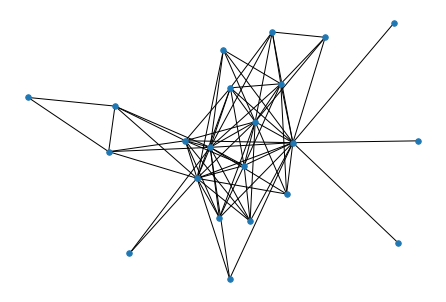

{'LCC': 22,
 'claw_count': 2339.0,
 'cpl': 1.8181818181818181,
 'd': 6.7272727272727275,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.2936117936117937,
 'n_components': 1,
 'node_num': 22,
 'power_law_exp': 1.6237504504501508,
 'rel_edge_distr_entropy': 0.9213688814313966,
 'square_count': 119,
 'triangle_count': 123,
 'wedge_count': 666.0}


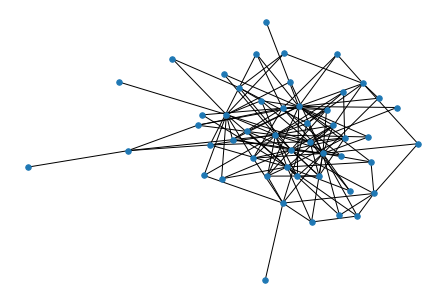

{'LCC': 50,
 'claw_count': 4330.0,
 'cpl': 2.3159183673469386,
 'd': 5.6,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 140,
 'gini': 0.35271428571428576,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6868318087885417,
 'rel_edge_distr_entropy': 0.9330940874311653,
 'square_count': 0,
 'triangle_count': 37,
 'wedge_count': 1141.0}
[330/2000]: vae_loss:1.5053, prior_loss:0.0509
max tensor(5.1095, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.2674, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5276, 0.5222, 0.5228,  ..., 0.5150, 0.5243, 0.5220],
        [0.5222, 0.5811, 0.5187,  ..., 0.5333, 0.5898, 0.5612],
        [0.5228, 0.5187, 0.5222,  ..., 0.5233, 0.5241, 0.5201],
        ...,
        [0.5150, 0.5333, 0.5233,  ..., 0.5540, 0.5515, 0.5329],
        [0.5243, 0.5898, 0.5241,  ..., 0.5515, 0.6074, 0.5694],
        [0.5220, 0.5612, 0.5201,  ..., 0.5329, 0.5694, 0.6109]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


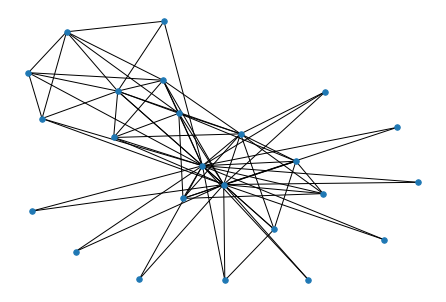

{'LCC': 24,
 'claw_count': 3243.0,
 'cpl': 1.7717391304347827,
 'd': 6.166666666666667,
 'd_max': 22.0,
 'd_min': 2.0,
 'edge_num': 74,
 'gini': 0.32376126126126126,
 'n_components': 1,
 'node_num': 24,
 'power_law_exp': 2.180219740524171,
 'rel_edge_distr_entropy': 0.9103838060041934,
 'square_count': 71,
 'triangle_count': 97,
 'wedge_count': 707.0}


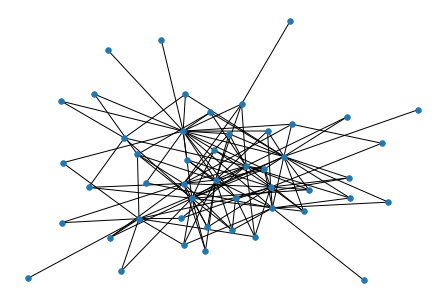

{'LCC': 48,
 'claw_count': 4356.0,
 'cpl': 2.265957446808511,
 'd': 5.333333333333333,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 128,
 'gini': 0.4013671875,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.7516286291811103,
 'rel_edge_distr_entropy': 0.9135228203445712,
 'square_count': 5,
 'triangle_count': 52,
 'wedge_count': 1108.0}
[360/2000]: vae_loss:1.6223, prior_loss:0.0336
max tensor(3.4634, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-1.1241, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5204, 0.5211, 0.5233,  ..., 0.5169, 0.5269, 0.5180],
        [0.5211, 0.5306, 0.5289,  ..., 0.5204, 0.5311, 0.5204],
        [0.5233, 0.5289, 0.6371,  ..., 0.5191, 0.5376, 0.5423],
        ...,
        [0.5169, 0.5204, 0.5191,  ..., 0.5195, 0.5366, 0.5134],
        [0.5269, 0.5311, 0.5376,  ..., 0.5366, 0.5903, 0.5175],
        [0.5180, 0.5204, 0.5423,  ..., 0.5134, 0.5175, 0.5235]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


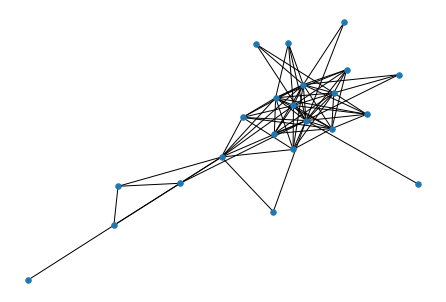

{'LCC': 22,
 'claw_count': 2282.0,
 'cpl': 1.8831168831168832,
 'd': 6.7272727272727275,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.28869778869778884,
 'n_components': 1,
 'node_num': 22,
 'power_law_exp': 1.6143030103342693,
 'rel_edge_distr_entropy': 0.924789157748091,
 'square_count': 142,
 'triangle_count': 129,
 'wedge_count': 658.0}


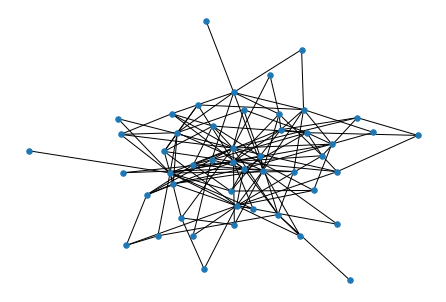

{'LCC': 49,
 'claw_count': 2342.0,
 'cpl': 2.358843537414966,
 'd': 5.346938775510204,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 131,
 'gini': 0.30565508646206574,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.6829220952468393,
 'rel_edge_distr_entropy': 0.9497455546490152,
 'square_count': 0,
 'triangle_count': 34,
 'wedge_count': 868.0}
[390/2000]: vae_loss:1.6928, prior_loss:0.0359
max tensor(4.2680, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.3931, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5178, 0.5186, 0.5212,  ..., 0.5222, 0.5256, 0.5101],
        [0.5186, 0.5204, 0.5207,  ..., 0.5224, 0.5256, 0.5105],
        [0.5212, 0.5207, 0.5976,  ..., 0.5378, 0.5304, 0.5213],
        ...,
        [0.5222, 0.5224, 0.5378,  ..., 0.5347, 0.5309, 0.5172],
        [0.5256, 0.5256, 0.5304,  ..., 0.5309, 0.5778, 0.4834],
        [0.5101, 0.5105, 0.5213,  ..., 0.5172, 0.4834, 0.5356]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


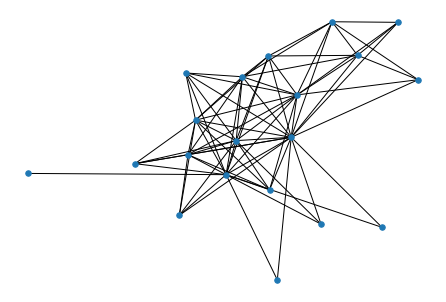

{'LCC': 20,
 'claw_count': 2341.0,
 'cpl': 1.631578947368421,
 'd': 7.4,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.23918918918918908,
 'n_components': 1,
 'node_num': 20,
 'power_law_exp': 1.5621588153435797,
 'rel_edge_distr_entropy': 0.9381915912775494,
 'square_count': 138,
 'triangle_count': 133,
 'wedge_count': 675.0}


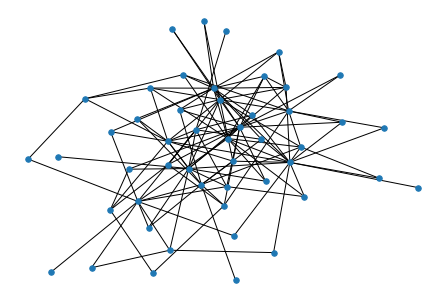

{'LCC': 49,
 'claw_count': 3031.0,
 'cpl': 2.4149659863945576,
 'd': 5.183673469387755,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 127,
 'gini': 0.3691145749638438,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.73897944405034,
 'rel_edge_distr_entropy': 0.9289415991583864,
 'square_count': 4,
 'triangle_count': 53,
 'wedge_count': 947.0}
[420/2000]: vae_loss:1.6691, prior_loss:0.0275
max tensor(6.4953, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.2572, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5233, 0.5203, 0.5150,  ..., 0.5195, 0.5215, 0.5208],
        [0.5203, 0.5537, 0.5224,  ..., 0.5285, 0.5192, 0.5141],
        [0.5150, 0.5224, 0.5246,  ..., 0.5167, 0.5175, 0.5018],
        ...,
        [0.5195, 0.5285, 0.5167,  ..., 0.5250, 0.5195, 0.5131],
        [0.5215, 0.5192, 0.5175,  ..., 0.5195, 0.5211, 0.5154],
        [0.5208, 0.5141, 0.5018,  ..., 0.5131, 0.5154, 0.5428]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


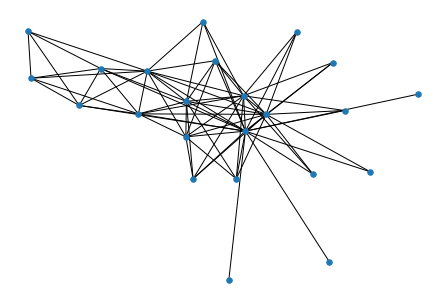

{'LCC': 23,
 'claw_count': 2538.0,
 'cpl': 1.7865612648221343,
 'd': 6.434782608695652,
 'd_max': 20.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3149236192714453,
 'n_components': 1,
 'node_num': 23,
 'power_law_exp': 1.643014435708534,
 'rel_edge_distr_entropy': 0.916074055573414,
 'square_count': 99,
 'triangle_count': 113,
 'wedge_count': 671.0}


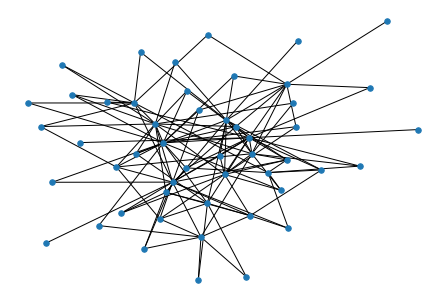

{'LCC': 50,
 'claw_count': 3511.0,
 'cpl': 2.3436734693877552,
 'd': 5.2,
 'd_max': 17.0,
 'd_min': 1.0,
 'edge_num': 130,
 'gini': 0.39030769230769224,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.752175635671637,
 'rel_edge_distr_entropy': 0.9219889533103859,
 'square_count': 3,
 'triangle_count': 50,
 'wedge_count': 1024.0}
[450/2000]: vae_loss:1.7157, prior_loss:0.0173
max tensor(4.5960, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.6229, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5202, 0.5195, 0.5188,  ..., 0.5213, 0.5203, 0.5137],
        [0.5195, 0.5278, 0.5366,  ..., 0.5163, 0.5200, 0.5130],
        [0.5188, 0.5366, 0.6207,  ..., 0.5265, 0.5183, 0.5159],
        ...,
        [0.5213, 0.5163, 0.5265,  ..., 0.5515, 0.5206, 0.4942],
        [0.5203, 0.5200, 0.5183,  ..., 0.5206, 0.5205, 0.5142],
        [0.5137, 0.5130, 0.5159,  ..., 0.4942, 0.5142, 0.5390]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


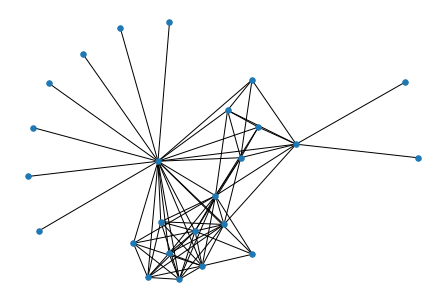

{'LCC': 25,
 'claw_count': 2639.0,
 'cpl': 1.8533333333333333,
 'd': 5.92,
 'd_max': 22.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.3632432432432433,
 'n_components': 1,
 'node_num': 25,
 'power_law_exp': 1.7559777722446346,
 'rel_edge_distr_entropy': 0.8923431468445747,
 'square_count': 131,
 'triangle_count': 124,
 'wedge_count': 676.0}


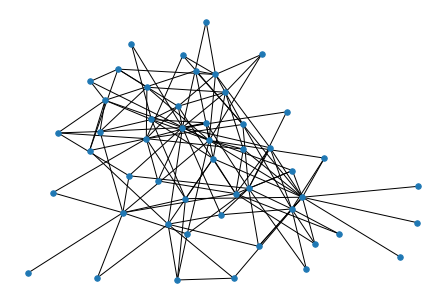

{'LCC': 50,
 'claw_count': 2222.0,
 'cpl': 2.4351020408163264,
 'd': 5.28,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 132,
 'gini': 0.3113636363636363,
 'n_components': 1,
 'node_num': 50,
 'power_law_exp': 1.6928241500792813,
 'rel_edge_distr_entropy': 0.949287971869009,
 'square_count': 0,
 'triangle_count': 29,
 'wedge_count': 859.0}
[480/2000]: vae_loss:1.6687, prior_loss:0.0159
max tensor(3.5720, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.4286, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5187, 0.5203, 0.5184,  ..., 0.5191, 0.5181, 0.5133],
        [0.5203, 0.5367, 0.5210,  ..., 0.5288, 0.5193, 0.5100],
        [0.5184, 0.5210, 0.5581,  ..., 0.5103, 0.5187, 0.5276],
        ...,
        [0.5191, 0.5288, 0.5103,  ..., 0.5297, 0.5182, 0.5028],
        [0.5181, 0.5193, 0.5187,  ..., 0.5182, 0.5175, 0.5131],
        [0.5133, 0.5100, 0.5276,  ..., 0.5028, 0.5131, 0.5274]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


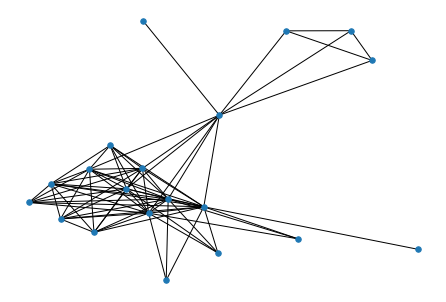

{'LCC': 20,
 'claw_count': 2164.0,
 'cpl': 1.8,
 'd': 7.4,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.24189189189189175,
 'n_components': 1,
 'node_num': 20,
 'power_law_exp': 1.5746781063886874,
 'rel_edge_distr_entropy': 0.9335546558156194,
 'square_count': 223,
 'triangle_count': 157,
 'wedge_count': 672.0}


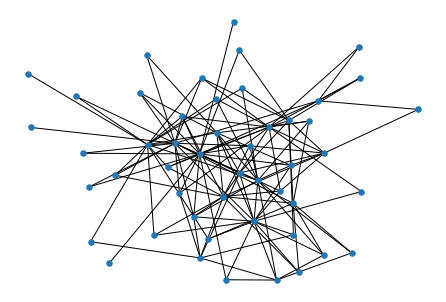

{'LCC': 49,
 'claw_count': 3771.0,
 'cpl': 2.304421768707483,
 'd': 5.428571428571429,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 133,
 'gini': 0.3742519564216664,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.716150673486994,
 'rel_edge_distr_entropy': 0.9267552440307224,
 'square_count': 4,
 'triangle_count': 45,
 'wedge_count': 1069.0}
[510/2000]: vae_loss:1.6687, prior_loss:0.0150
max tensor(3.7531, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.5180, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5209, 0.5209, 0.5170,  ..., 0.5172, 0.5197, 0.5209],
        [0.5209, 0.5351, 0.5077,  ..., 0.5200, 0.5119, 0.5209],
        [0.5170, 0.5077, 0.5680,  ..., 0.5383, 0.5336, 0.5170],
        ...,
        [0.5172, 0.5200, 0.5383,  ..., 0.5343, 0.5236, 0.5172],
        [0.5197, 0.5119, 0.5336,  ..., 0.5236, 0.5339, 0.5197],
        [0.5209, 0.5209, 0.5170,  ..., 0.5172, 0.5197, 0.5209]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


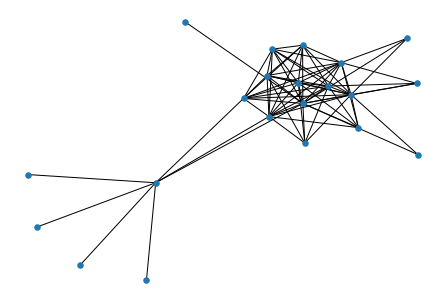

{'LCC': 21,
 'claw_count': 2237.0,
 'cpl': 1.8952380952380952,
 'd': 7.0476190476190474,
 'd_max': 16.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.28957528957528944,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.6369163343601625,
 'rel_edge_distr_entropy': 0.9132308521604303,
 'square_count': 256,
 'triangle_count': 163,
 'wedge_count': 687.0}


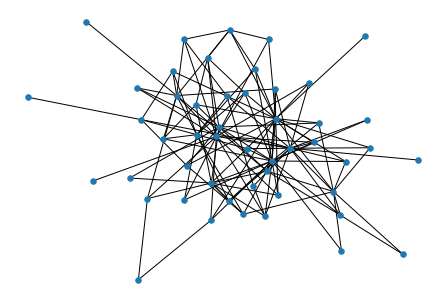

{'LCC': 49,
 'claw_count': 4537.0,
 'cpl': 2.2950680272108843,
 'd': 5.469387755102041,
 'd_max': 21.0,
 'd_min': 1.0,
 'edge_num': 134,
 'gini': 0.3563813585135547,
 'n_components': 1,
 'node_num': 49,
 'power_law_exp': 1.7054513463649825,
 'rel_edge_distr_entropy': 0.9275807044577319,
 'square_count': 1,
 'triangle_count': 48,
 'wedge_count': 1119.0}
[540/2000]: vae_loss:1.6451, prior_loss:0.0125
max tensor(4.5588, device='cuda:0', grad_fn=<MaxBackward1>) min tensor(-0.9373, device='cuda:0', grad_fn=<MinBackward1>)
rec_adj w/ sigmoid tensor([[0.5184, 0.5184, 0.5184,  ..., 0.5167, 0.5263, 0.5146],
        [0.5184, 0.5184, 0.5184,  ..., 0.5167, 0.5263, 0.5146],
        [0.5184, 0.5184, 0.5184,  ..., 0.5167, 0.5263, 0.5146],
        ...,
        [0.5167, 0.5167, 0.5167,  ..., 0.5273, 0.5180, 0.5136],
        [0.5263, 0.5263, 0.5263,  ..., 0.5180, 0.5999, 0.5005],
        [0.5146, 0.5146, 0.5146,  ..., 0.5136, 0.5005, 0.5282]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


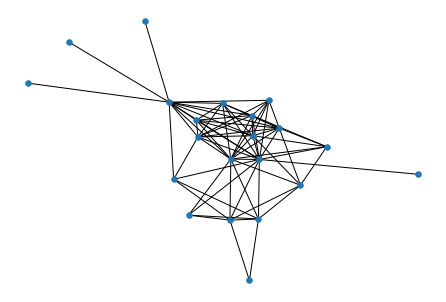

{'LCC': 21,
 'claw_count': 1946.0,
 'cpl': 1.8142857142857143,
 'd': 7.0476190476190474,
 'd_max': 15.0,
 'd_min': 1.0,
 'edge_num': 74,
 'gini': 0.2503217503217503,
 'n_components': 1,
 'node_num': 21,
 'power_law_exp': 1.6072518090349064,
 'rel_edge_distr_entropy': 0.9304549603753052,
 'square_count': 183,
 'triangle_count': 141,
 'wedge_count': 640.0}


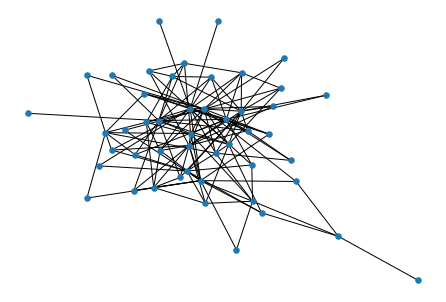

{'LCC': 48,
 'claw_count': 3572.0,
 'cpl': 2.328014184397163,
 'd': 5.75,
 'd_max': 18.0,
 'd_min': 1.0,
 'edge_num': 138,
 'gini': 0.3440519323671498,
 'n_components': 1,
 'node_num': 48,
 'power_law_exp': 1.6742889734442161,
 'rel_edge_distr_entropy': 0.9372393153546903,
 'square_count': 5,
 'triangle_count': 57,
 'wedge_count': 1082.0}


KeyboardInterrupt: ignored

In [0]:
## Implement VAE/GAE Here to check the results

av_size = 0  # set 0 if you do not need attr_vec
# d_size = 8
#z_size = 64
#gc_size = 16
d_size = 50 #16
z_size = 32
gc_size = 16
rep_size = 16
z_out_size = z_size + av_size

adj_thresh = .5
max_epochs = 2000
lr = 0.001


beta = 5
alpha = 0.1
gamma = 15

G = Generator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size,
    z_size=z_size,
    z_out_size=z_out_size,
    rep_size=rep_size
).cuda()
'''
D = Discriminator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size
).cuda()
'''
criterion_bce = nn.BCELoss()
criterion_bce.cuda()

loss_MSE = nn.MSELoss()
loss_MSE.cuda()   
loss_BCE = nn.BCELoss()
loss_BCE.cuda()      
  
for name, param in G.named_parameters():
	print(name, '      ', param.size())
# I won't use the next 3 lines
opt_enc = optim.RMSprop(G.encoder.parameters(), lr=lr)
opt_dec = optim.RMSprop(G.decoder.parameters(), lr=lr)
#opt_dis = optim.RMSprop(D.parameters(), lr=lr * alpha)

#opt_vae = optim.RMSprop(G.parameters(), lr=lr)
opt_vae = optim.Adam(G.parameters(), lr=lr)


for epoch in range(max_epochs):
    D_real_list, D_rec_enc_list, D_rec_noise_list, D_list = [], [], [], []
    # g_loss_list, rec_loss_list, prior_loss_list = [], [], []
    g_loss_list, rec_loss_list, prior_loss_list, aa_loss_list = [], [], [], []
    # for i in range(len(t_adj_mats)):
    # Only train the 8th graph
    for i in range(8, 9): 
        
        ones_label = Variable(torch.ones(1)).cuda()
        zeros_label = Variable(torch.zeros(1)).cuda()
        edge_num = t_adj_mats[i].sum()
        adj = Variable(t_adj_mats[i]).cuda()
        #if adj.shape[0] <= d_size:
        #    continue
            
        if av_size == 0:
            attr_vec = None
        else:
            attr_vec = Variable(t_attr_vecs[i, :]).cuda()
        
        G.set_attr_vec(attr_vec)
        #D.set_attr_vec(attr_vec)
        
        norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
        pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
        # print('pos_weight', pos_weight)
        mean, logvar, rec_adj = G(adj, training=True)
        
        noisev = torch.randn(mean.shape, requires_grad=True).cuda()
        noisev = cat_attr(noisev, attr_vec)
        rec_noise = G.decoder(noisev)
        '''
        # train discriminator
        output = D(adj)
        errD_real = criterion_bce(output, ones_label)
        D_real_list.append(output.data.mean())
        output = D(rec_adj)
        errD_rec_enc = criterion_bce(output, zeros_label)
        D_rec_enc_list.append(output.data.mean())
        output = D(rec_noise)
        errD_rec_noise = criterion_bce(output, zeros_label)
        D_rec_noise_list.append(output.data.mean())
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise
        # print ("print (dis_img_loss)", dis_img_loss)
        D_list.append(dis_img_loss.data.mean())
        opt_dis.zero_grad()
        dis_img_loss.backward(retain_graph=True)
        opt_dis.step()
        '''
        loss_BCE_logits = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss_BCE_logits.cuda() 
        
        # AA_loss b/w rec_adj and adj
        # aa_loss = loss_MSE(rec_adj, adj)
        # aa_loss = loss_BCE_logits(rec_adj, adj)
        #b_adj=F.sigmoid(rec_adj)
        #b_adj[F.sigmoid(rec_adj)<=0.6] =0
        #c_adj = sample_adj(b_adj)
        
        c_adj = topk_adj(F.sigmoid(rec_adj), int(edge_num.numpy()))
        aa_loss = loss_BCE(c_adj, adj)
        
        # fix me: sum version of prior loss
        pl = []
        for i in range(mean.size()[0]):
            prior_loss = 1 + logvar[i, :] - mean[i, :].pow(2) - logvar[i, :].exp()
            prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean[i, :].data)
            pl.append(prior_loss)
        prior_loss_list.append(sum(pl))
        kl_loss = sum(pl)/torch.numel(mean[i, :].data)
        vae_loss = kl_loss + norm*aa_loss
        opt_vae.zero_grad()
        vae_loss.backward() #retain_graph=True
        opt_vae.step()
        
    if epoch % 30 == 0:   
        _,_, rec_adj = G(adj, training=False)
        b_adj = F.sigmoid(rec_adj)
        b_adj[F.sigmoid(rec_adj)<=0.5] =0
        c_adj = sample_adj(b_adj)
        
        print('[%d/%d]: vae_loss:%.4f, prior_loss:%.4f' 
               % (epoch, 
                  max_epochs, 
                  torch.mean(torch.stack([vae_loss])),
                  torch.mean(torch.stack(prior_loss_list))))

        print('max',(rec_adj.max()),'min',(rec_adj.min()))
       
        print('rec_adj w/ sigmoid', F.sigmoid(rec_adj))
        #148
        # print(edge_num.numpy(),'edge_num')
        show_graph(topk_adj(F.sigmoid(rec_adj), int(edge_num.numpy()) ), thresh=adj_thresh)
        show_graph(topk_adj(c_adj, int(edge_num.numpy())), thresh=0)


In [0]:
av_size = 0  # set 0 if you do not need attr_vec
# d_size = 8
#z_size = 64
#gc_size = 16
d_size = 16
z_size = 16
gc_size = 32
z_out_size = z_size + av_size
rep_size = 32

adj_thresh = .7
max_epochs = 1000
lr = 3e-4


beta = 5
alpha = 0.1
gamma = 15

G = Generator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size,
    z_size=z_size,
    z_out_size=z_out_size,
    rep_size=rep_size
).cuda()

D = Discriminator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size
).cuda()

criterion_bce = nn.BCELoss()
criterion_bce.cuda()

loss_MSE = nn.MSELoss()
loss_MSE.cuda()      
loss_BCE = nn.BCEWithLogitsLoss()#size_average=False)
loss_BCE.cuda()      


# loss for A and A'
# todo: add the loss to main
criterion_bcell = nn.BCEWithLogitsLoss()
criterion_bcell.cuda()


opt_enc = optim.RMSprop(G.encoder.parameters(), lr=lr)
opt_dec = optim.RMSprop(G.decoder.parameters(), lr=lr)
opt_dis = optim.RMSprop(D.parameters(), lr=lr * alpha)

for epoch in range(max_epochs):
    D_real_list, D_rec_enc_list, D_rec_noise_list, D_list = [], [], [], []
    # g_loss_list, rec_loss_list, prior_loss_list = [], [], []
    g_loss_list, rec_loss_list, prior_loss_list, aa_loss_list = [], [], [], []
    # for i in range(len(t_adj_mats)):
    # Only train the 8th graph
    for i in range(8, 9): 
        ones_label = Variable(torch.ones(1)).cuda()
        zeros_label = Variable(torch.zeros(1)).cuda()
        
        adj = Variable(t_adj_mats[i]).cuda()
        if adj.shape[0] <= d_size:
            continue
            
        if av_size == 0:
            attr_vec = None
        else:
            attr_vec = Variable(t_attr_vecs[i, :]).cuda()
        
        G.set_attr_vec(attr_vec)
        D.set_attr_vec(attr_vec)
        
        mean, logvar, rec_adj = G(adj)
        
        noisev = torch.randn(mean.shape, requires_grad=True).cuda()
        noisev = cat_attr(noisev, attr_vec)
        rec_noise = G.decoder(noisev)
        
        # train discriminator
        output = D(adj)
        errD_real = criterion_bce(output, ones_label)
        D_real_list.append(output.data.mean())
        output = D(rec_adj)
        errD_rec_enc = criterion_bce(output, zeros_label)
        D_rec_enc_list.append(output.data.mean())
        output = D(rec_noise)
        errD_rec_noise = criterion_bce(output, zeros_label)
        D_rec_noise_list.append(output.data.mean())
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise
        # print ("print (dis_img_loss)", dis_img_loss)
        D_list.append(dis_img_loss.data.mean())
        opt_dis.zero_grad()
        dis_img_loss.backward(retain_graph=True)
        opt_dis.step()
        
        
        # AA_loss b/w rec_adj and adj
        #aa_loss = loss_MSE(rec_adj, adj)
        aa_loss = loss_BCE(rec_adj, adj)
        
        # train decoder
        output = D(adj)
        errD_real = criterion_bce(output, ones_label)
        output = D(rec_adj)
        errD_rec_enc = criterion_bce(output, zeros_label)
        output = D(rec_noise)
        errD_rec_noise = criterion_bce(output, zeros_label)
        
        similarity_rec_enc = D.similarity(rec_adj)
        similarity_data = D.similarity(adj)
        
        dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise 
        # print (dis_img_loss)
        gen_img_loss = aa_loss + errD_rec_enc # - dis_img_loss 
        
        g_loss_list.append(gen_img_loss.data.mean())
        rec_loss = ((similarity_rec_enc - similarity_data) ** 2).mean()
        rec_loss_list.append(rec_loss.data.mean())
        err_dec = gamma * rec_loss + gen_img_loss
        
        opt_dec.zero_grad()
        err_dec.backward(retain_graph=True)
        opt_dec.step()
        
        # train encoder
        # fix me: sum version of prior loss
        pl = []
        for i in range(mean.size()[0]):
            prior_loss = 1 + logvar[i, :] - mean[i, :].pow(2) - logvar[i, :].exp()
            prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean[i, :].data)
            pl.append(prior_loss)
        prior_loss_list.append(sum(pl))
        err_enc = sum(pl) + beta * rec_loss
        
        opt_enc.zero_grad()
        err_enc.backward()
        opt_enc.step()
    if epoch % 50 == 0:   
        print('[%d/%d]: D_real:%.4f, D_enc:%.4f, D_noise:%.4f, Loss_D:%.4f, Loss_G:%.4f, rec_loss:%.4f, prior_loss:%.4f' 
               % (epoch, 
                  max_epochs, 
                  torch.mean(torch.stack(D_real_list)), 
                  torch.mean(torch.stack(D_rec_enc_list)), 
                  torch.mean(torch.stack(D_rec_noise_list)), 
                  torch.mean(torch.stack(D_list)), 
                  torch.mean(torch.stack(g_loss_list)),
                  torch.mean(torch.stack(rec_loss_list)),
                  torch.mean(torch.stack(prior_loss_list))))
        print(F.sigmoid(rec_adj).cpu())
        show_graph(F.sigmoid(rec_adj), thresh=adj_thresh)
        
        #show_graph(rec_adj, thresh=adj_thresh)


In [0]:
def test_gen(model, n, attr_vec):
    fixed_noise = torch.randn((n, z_size), requires_grad=True).cuda()
    if attr_vec:
        fixed_noise = cat_attr(fixed_noise, attr_vec.cuda())
    a_ = model.decoder(fixed_noise)
    show_graph(F.sigmoid(a_), thresh=.53)

for _ in range(5):
    test_gen(G, 40, None)

# for _ in range(5):
#     test_gen(G, 10, t_attr_vecs[1, :])
    

In [0]:
print(G)
print(D)